In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
data = pd.read_table("seeds_dataset.txt", sep="\s+", header=None)

In [3]:
data

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


# PCA and K-means from scratch 

## PCA

In [4]:
def pca(data: np.array, dimension: int) -> np.array:
    """
    This is the function that is from scratch to implement pca.
    The return is the projection result.
    """
    # Calculatethe empirical covariance matrix.
    Sigma = np.cov(data.T, ddof = 0)
    # SVD decomposition.
    U,sigma,VT = np.linalg.svd(Sigma)
    # Select the first k dimension in U (k is the objective dimension)
    U_index = np.argsort(-sigma)[:2]
    U = U[:, U_index]
    return (U.T.dot((data - data.mean(axis = 0)).T)).T

## K-means

In [5]:
def kmeans(data: np.array, cluster: int, max_iteration: int = 10000) -> tuple:
    """
    This is the function that is from scratch to implement kmeans.
    The return is a tuple. The first element is a numpy array of all centroid and the second element is the assigned data.
    """
    
    # Randomly assign initial centroid.
    index_range = range(len(data))
    centroid_range = np.random.choice(index_range, cluster)
    centroid = data[centroid_range]
    print(centroid)
    
    # Create a column to contian the r (the assignment).
    data =  np.column_stack((data, np.zeros(len(data))))
    
    for _ in range(max_iteration):
        # Update assignment r.
        assignemnt_last = copy.deepcopy(data[:, -1])
        for i in range(len(data)):
            difference = data[i, :-1] - centroid
            distance = np.linalg.norm(difference, axis = 1)
            data[i,-1] = np.argmin(distance)
        if (assignemnt_last == data[:, -1]).all():
            # Here is the case that the r does not change, which means the model has converged now.
            break

        # Update cluster centers c.
        for i in range(cluster):
            cluster_data  = data[data[:, -1] == i][:, :-1]
            centroid[i] = cluster_data.mean(axis = 0)
    return (centroid, data) 

In [6]:
data_projection = pca(data.values[:, :-1], 2)

In [7]:
data_projection

array([[-0.66344838, -1.41732098],
       [-0.31566651, -2.68922915],
       [ 0.6604993 , -1.13150635],
       [ 1.0552759 , -1.62119002],
       [-1.61999921, -2.18338442],
       [ 0.47693801, -1.33649437],
       [ 0.18483472, -0.15036441],
       [ 0.78062962, -1.12979883],
       [-2.2821081 , -1.3600169 ],
       [-1.97854147, -1.49468793],
       [-0.36912295,  0.88672251],
       [ 0.7110212 , -2.1066373 ],
       [ 1.21370535,  0.09468789],
       [ 1.16908541, -0.7429629 ],
       [ 1.19272176, -0.95326816],
       [ 0.50817121,  0.37795842],
       [ 1.37469698,  1.32290559],
       [-1.05726438, -2.01562875],
       [ 0.1509611 , -2.02235813],
       [ 2.46241293,  0.07374738],
       [ 0.6313321 , -0.71830566],
       [ 0.68969866, -1.11182531],
       [-1.40769072, -2.80658086],
       [ 2.84267672, -2.66880642],
       [-0.43326822, -1.88984464],
       [-1.81289158, -2.60002176],
       [ 2.02131332, -0.60874333],
       [ 2.19571862, -1.49837622],
       [ 0.74446884,

In [8]:
centroid, assigned_data = kmeans(data_projection, 3)

[[ 1.83336074  0.73069309]
 [ 3.96469498 -0.86703146]
 [-3.86089703 -0.37351327]]


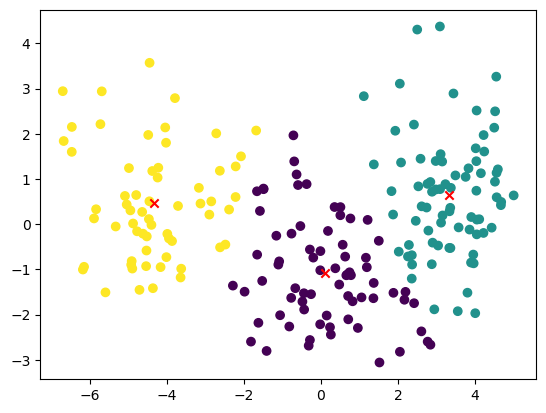

In [9]:
plt.scatter(data_projection[:, 0], data_projection[:, 1], c=assigned_data[:, -1], cmap='viridis')
plt.scatter(centroid[:, 0], centroid[:, 1], c = "red", marker = "x")

# Evaluation metrics from scratch

## Silhouette Coefficient 

$$a(i) = \frac{\sum\limits_{j\in C_i, j \neq i}{d(i, j)}}{|C_i - 1|}, \forall i \in C_i$$
$$b(i) = \min\limits_{k\neq i}\frac{\sum_{j\in C_{k}}{d(i, j)}}{|C_k|}$$
$$ s(i)=\left\{
\begin{aligned}
\frac{b(i) - a(i)}{\max(a(i), b(i))},\space &if |C_i| > 1 \\
0 ,\space &if |C_i| = 1
\end{aligned}
\right.
$$
for cluster k, $\bar{s}(k)$ is the mean of all the points in the cluster.
$$SC = \max{\bar{s}(k)}$$

In [10]:
def silhouette_coefficient(data: np.array, cluster: int) -> float:
    """
    This is the function that is from scratch to implement silhouette coefficient to evaluate the performance of clustering.
    The return is a float that is the performance of clustering.
    """
    # s_D is a dict to store s in different clusters.
    s_D = {}
    for i in range(cluster):
        s_D[i] =[]
        
    for i in range(len(data)):
        cluster_index = data[i, -1]
        cluster_data = data[data[:, -1] == cluster_index][:, :-1]
        if len(cluster_data) == 1:
            s_D[cluster_index].append(0)
            continue
        difference = data[i, :-1] - cluster_data
        distance = np.linalg.norm(difference, axis = 1)
        a = distance.sum()/(len(distance) - 1)
        cluster_range = list(range(cluster))
        cluster_range.remove(cluster_index)
        
        # Use a list to store the distance to the data of other clusters.
        other_distances = []
        for k in cluster_range:
            cluster_data = data[data[:, -1] == k][:, :-1]
            difference = data[i, :-1] - cluster_data
            distance = np.linalg.norm(difference, axis = 1)
            other_distances.append(distance.mean())
            
        b = np.min(other_distances)
        
        s_D[cluster_index].append((b - a)/max(a, b))
        
    # Use a list to store s bar
    s_bar = []
    for k, v in s_D.items():
        s_bar.append(np.mean(v))
        
    return np.max(s_bar)

## Rand Index

$$IR = \frac{a+b}{a + b + c + d}$$
X is the observation and Y is the predicted result.\
a, the number of pairs of elements in S that are in the same subset in X and in the same subset in Y.\
b, the number of pairs of elements in S that are in different subsets in X and in different subsets in Y.\
c, the number of pairs of elements in S that are in the same subset in X and in different subsets in Y.\
d, the number of pairs of elements in S that are in different subsets in X and in the same subset in Y.

In [11]:
def rand_index(observation: np.array, predicted: np.array) -> float:
    """
    This is the function that is from scratch to implement rand index to evaluate the performance of clustering.
    The return is a float that is the performance of clustering.
    """
    a = b = c = d = 0
    
    for i in range(len(observation)):
        for j in range(i+1, len(observation)):
            if observation[i] == observation[j] and predicted[i] == predicted[j]:
                a += 1
            elif observation[i] != observation[j] and predicted[i] != predicted[j]:
                b += 1
            elif observation[i] == observation[j] and predicted[i] != predicted[j]:
                c += 1
            elif observation[i] != observation[j] and predicted[i] == predicted[j]:
                d += 1
    
    return (a + b) / (a + b + c + d)

In [12]:
sc = silhouette_coefficient(assigned_data, 3)
ri = rand_index(data.values[:, -1],  assigned_data[:, -1])

print("Silhouette Coefficient: {:.4f}".format(sc))
print("Rand Index: {:.4f}".format(ri))

Silhouette Coefficient: 0.5463
Rand Index: 0.8744
